In [21]:
import importlib

In [1]:
import scipy
import scipy.stats as sp
import scipy.optimize as spopt

import emcee
import batman
import corner

from astropy import constants as const
from astropy import units

import numpy as np
import time as t
import timeit
import os, sys
import csv

from multiprocessing import Pool
from threadpoolctl import threadpool_limits

import inspect

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.time
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.io import fits

import urllib.request

# SPCA libraries
from SPCA import helpers, astro_models, make_plots, make_plots_custom, detec_models, bliss

from SPCA import Decorrelation_helper as dh

In [2]:
# planet = 'KELT-16b'
planet = 'KELT16b'
channel = 'ch2'
mode = 'BLISS_v1_junkRun'
# rootpath = '/home/taylor/Documents/Research/spitzer/MEGA/'
rootpath = '/home/taylor/Documents/Research/spitzer/'

# parameters you do not wish to fit
dparams_input = []#['ecosw','esinw']

# parameters you want to place a gaussian prior on
gparams = ['t0', 'per', 'a', 'inc']

# parameters you want to place a uniform prior on
uparams = ['gpLx', 'gpLy']
uparams_limits = [[0,-3],[0,-3]]

ncpu = 2                                 # The number of cpu threads to be used when running MCMC
runMCMC = False                          # whether to run MCMC or just load-in past results
nBurnInSteps1 = 1e5                      # number of steps to use for the first mcmc burn-in (only used if not doing GP)
nBurnInSteps2 = 1e6                      # number of steps to use for the second mcmc burn-in
nProductionSteps = 2e5                   # number of steps to use with mcmc production run
usebestfit = False                       # used best-fit instead of most probable parameters 
blissNBin = 8                            # number of knots to allow in each direction
secondOrderOffset = False                # should you use the second order sinusoid terms when calculating offset
bestfitNbin = 50                         # the number of binned values to overplot on the bestfit 4-panel figure (use None if you don't want these overplotted)
nFrames  = 64                            # number of frames per binned data point
initializeWithOld = False                # initial with previous mcmc results using the same method
pldIgnoreFrames = True                   # Whether or not to use the PLD photometry that ignored bad frames
pldAddStack = False                      # Whether or not to use the PLD photometry that used background correction stacks
debug = False                            # True if user wants details about the lambda functions created

#non-unity if you have dilution by a nearby companion
compFactor = 1.

# non-zero if you want to remove some initial data points
cut_tmp = 0

In [3]:
if rootpath[-1]!='/':
    rootpath += '/'

with open(rootpath+planet+'/analysis/'+channel+'/cutFirstAOR.txt', 'r') as file:
    cutFirstAOR = file.readline().strip()=='True'

# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams_input, mode)


## Download the most recent exoplanet archive data, and select the best constrained value for each parameter
dh.downloadExoplanetArchive()
p0_obj = dh.loadArchivalData(rootpath, planet, channel)


## If you would rather load your own data (e.g. your planet isn't in the exoplanet archive),
## you can use the function below. The error parameters are optional inputs, but are required if you want
## to put a prior on a parameter.
# p0_obj = loadCustomData(rootpath, planet, channel, rp, a, per, t0, inc, e, argp, Tstar, logg, feh,
#                         rp_err, a_err, t0_err, per_err, inc_err, e_err, argp_err, Tstar_err)

In [4]:
# set up Gaussian priors
priors, errs = dh.setup_gpriors(gparams, p0_obj)

In [5]:
(foldername, filename, filename_full, savepath,
 path_params, AOR_snip, aors, ignoreFrames) = dh.findPhotometry(rootpath, planet, channel,
                                                                mode, pldIgnoreFrames, pldAddStack)

breaks = dh.find_breaks(rootpath, planet, channel, aors)

sigF_photon_ppm = dh.get_photon_limit(rootpath, foldername+filename, planet, channel, mode, aors, nFrames, ignoreFrames)

gparams_unsorted = np.copy(gparams)
gparams = np.array([parm for parm in p0_obj['params'] if parm in gparams])

uparams_unsorted = np.copy(uparams)
uparams = np.array([parm for parm in p0_obj['params'] if parm in uparams])

In [6]:
signalfunc, detecfunc = dh.get_detector_functions(mode)

## Load data

In [7]:
# For datasets where the first AOR is peak-up data
if cutFirstAOR:
    rawfiles = np.sort(os.listdir(rootpath+planet+'/data/'+channel+'/'+aors[0]+'/'+channel+'/bcd/'))
    rawfiles  = [rawfile for rawfile in rawfiles if '_bcd.fits' in rawfile]
    cut = cut_tmp+len(rawfiles)
else:
    cut = cut_tmp

# loading full data set for BIC calculation afterwards
if 'pld' in mode.lower():
    # get data from unbinned photometry for chi2 on unbinned data calculation later
    P_full, flux_full, time_full = helpers.get_full_data(foldername+filename_full, mode,
                                                         cut=cut, nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    Pnorm_0, flux0, time0 = helpers.get_data(foldername+filename, mode)
    Pnorm, flux, time = helpers.get_data(foldername+filename, mode, cut=cut)
    
    # FIX: Add an initial PLD plot
else:
    # get data from photometry
    (flux_full, fluxerr_full, time_full, xdata_full, ydata_full,
     psfxw_full, psfyw_full) = helpers.get_full_data(foldername+filename_full, mode, cut=cut,
                                                     nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    (flux0, flux_err0, time0, xdata0, ydata0,
     psfxw0, psfyw0) = helpers.get_data(foldername+filename, mode)
    (flux, flux_err, time, xdata, ydata,
     psfxw, psfyw) = helpers.get_data(foldername+filename, mode, cut=cut)

    ## FIX: peritime doesn't get made
    if True:#'ecosw' in dparams_input and 'esinw' in dparams_input:
        # make photometry plots
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                        time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath)
    else:
        # plot raw data
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                        time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath, peritime)

In [8]:
# declare where the heaviside break occurs
if 'hside' in mode.lower():
    # FIX: This is fully broken right now
    p0_obj['s2'] = timeaor1
    dparams = np.append(dparams, ['s2'])

# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams_input, mode)  

# if you want to use the best fit params from a previous MCMC run            
if initializeWithOld:
    dh.reload_old_fit(path_params, p0_obj)

In [9]:
# get p0
p0, p0_labels, p0_fancyLabels = helpers.get_p0(dparams, p0_obj)

# make lambda functions to freeze certain inputs
astrofunc = helpers.make_lambdafunc(astro_models.ideal_lightcurve, dparams, p0_obj, debug=debug)
detecfunc = helpers.make_lambdafunc(detecfunc, dparams, p0_obj, debug=debug)
psfwifunc = helpers.make_lambdafunc(detec_models.detec_model_PSFW, dparams, p0_obj, debug=debug)
hsidefunc = helpers.make_lambdafunc(detec_models.hside, dparams, p0_obj, debug=debug)
tslopefunc = helpers.make_lambdafunc(detec_models.tslope, dparams, p0_obj, debug=debug)
lnpriorfunc = helpers.make_lambdafunc(helpers.lnprior, dparams, obj=p0_obj, debug=debug)
signalfunc = helpers.make_lambdafunc(signalfunc, dparams, obj=p0_obj, debug=debug)

if gparams != [] or uparams != []:
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    upriorInds = [np.where(p0_labels==upar)[0][0] for upar in uparams if upar in p0_labels]
    if 'gp' in mode.lower():
        gammaInd = np.where(p0_labels=='gpAmp')[0][0]
    else:
        gammaInd = None
    lnprior_custom = lambda p0: (helpers.lnprior_gaussian(p0, gpriorInds, priors, errs)+
                                 helpers.lnprior_uniform(p0, upriorInds, uparams_limits)+
                                 helpers.lnprior_gamma(p0, gammaInd, 1, 100))
else:
    lnprior_custom = None

# detemining which params in p0 are part of which functions
p0_astro  = helpers.get_fitted_params(astro_models.ideal_lightcurve, dparams)
p0_detec = helpers.get_fitted_params(detecfunc, dparams)
p0_psfwi  = helpers.get_fitted_params(detec_models.detec_model_PSFW, dparams)
p0_hside  = helpers.get_fitted_params(detec_models.hside, dparams)
p0_tslope  = helpers.get_fitted_params(detec_models.tslope, dparams)

# initial astro model
astro_guess = astrofunc(time, **dict([[p0_astro[i], p0[np.where(np.in1d(p0_labels,p0_astro))][i]] for i in range(len(p0_astro))]))
resid       = flux/astro_guess

if 'bliss' in mode.lower():
    make_plots.plot_centroids(xdata0, ydata0, xdata, ydata, savepath)

    signal_inputs = bliss.precompute(flux, time, xdata, ydata, psfxw, psfyw, mode,
                                     astro_guess, blissNBin, savepath)
elif 'gp' in mode.lower():
    signal_inputs = [flux, time, xdata, ydata, psfxw, psfyw, mode]
    detec_inputs = [flux, xdata, ydata, time, True, astro_guess]
elif 'pld' in mode.lower():
    signal_inputs = [flux, time, Pnorm, mode]
    detec_inputs  = [Pnorm, mode]
elif 'poly' in mode.lower():
    signal_inputs = [flux, time, xdata, ydata, psfxw, psfyw, mode]
    detec_inputs = [xdata, ydata, mode]

# Run initial optimization

### If not GP, Run initial optimization on just the detector parameters

In [10]:
# Run a first fit on the detector parameters to get into the right ballpark
if runMCMC:
    if not initializeWithOld and 'bliss' not in mode.lower() and 'gp' not in mode.lower():
        # Should work for PLD and Poly
        
        spyFunc0 = lambda p0_temp, inputs: np.mean((resid-detecfunc(inputs, **dict([[p0_detec[i], p0_temp[i]] for i in range(len(p0_detec))])))**2)
        spyResult0 = scipy.optimize.minimize(spyFunc0, p0[np.where(np.in1d(p0_labels,p0_detec))], detec_inputs, 'Nelder-Mead')

        # replace p0 with new detector coefficient values
        p0[np.where(np.in1d(p0_labels,p0_detec))] = spyResult0.x
        resid /= detecfunc(detec_inputs, **dict([[p0_detec[i], p0[np.where(np.in1d(p0_labels,p0_detec))][i]] for i in range(len(p0_detec))]))

        # 2) get initial guess for psfw model
        if 'psfw' in mode.lower():
            spyFunc0 = lambda p0_temp: np.mean((resid-psfwifunc([psfxw, psfyw], **dict([[p0_pfswi[i], p0_temp[i]] for i in range(len(p0_pfswi))])))**2)
            spyResult0 = scipy.optimize.minimize(spyFunc0, p0[np.where(np.in1d(p0_labels,p0_psfwi))], method='Nelder-Mead')

            # replace p0 with new detector coefficient values
            if spyResult0.success:
                p0[np.where(np.in1d(p0_labels,p0_psfwi))] = spyResult0.x
                resid /= psfwifunc([psfxw, psfyw], **dict([[p0_detec[i], p0[np.where(np.in1d(p0_labels,p0_pfswi))][i]] for i in range(len(p0_pfswi))]))

        # 3) get initial guess for hside model
        if 'hside' in mode.lower():
            spyFunc0 = lambda p0_temp: np.mean((resid-hsidefunc(time, **dict([[p0_hside[i], p0_temp[i]] for i in range(len(p0_hside))])))**2)
            spyResult0 = scipy.optimize.minimize(spyFunc0, p0[np.where(np.in1d(p0_labels,p0_hside))], method='Nelder-Mead')

            # replace p0 with new detector coefficient values
            if spyResult0.success:
                p0[np.where(np.in1d(p0_labels,p0_hside))] = spyResult0.x
                resid /= hsidefunc(time, **dict([[p0_detec[i], p0[np.where(np.in1d(p0_labels,p0_hside))][i]] for i in range(len(p0_hside))]))

        if 'tslope' in mode.lower():
            spyFunc0 = lambda p0_temp: np.mean((resid-tslopefunc(time, **dict([[p0_tslope[i], p0_temp[i]] for i in range(len(p0_tslope))])))**2)
            spyResult0 = scipy.optimize.minimize(spyFunc0, p0[np.where(np.in1d(p0_labels,p0_tslope))], method='Nelder-Mead')

            # replace p0 with new detector coefficient values
            if spyResult0.success:
                p0[np.where(np.in1d(p0_labels,p0_tslope))] = spyResult0.x
                resid /= tslopefunc(time, **dict([[p0_detec[i], p0[np.where(np.in1d(p0_labels,p0_tslope))][i]] for i in range(len(p0_tslope))]))


    # initial guess
    signal_guess = signalfunc(signal_inputs, **dict([[p0_labels[i], p0[i]] for i in range(len(p0))]))
    #includes psfw and/or hside functions if they're being fit
    detec_full_guess = signal_guess/astro_guess
    
    make_plots.plot_init_guess(time, flux, astro_guess, detec_full_guess)
    plt.show()
    plt.close()

### If GP, run initial full optimization to find best location

In [11]:
if runMCMC and 'gp' in mode.lower():
    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    initial_lnprob = helpers.lnprob(p0, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)

    spyFunc_full = lambda p0_temp, inputs: -helpers.lnprob(p0_temp, *inputs)

    nIterScipy = 10
    
    final_lnprob = -np.inf
    p0_optimized = []
    p0_temps = []
    print('Running iterative scipy.optimize')
    from tqdm import tqdm
    for i in tqdm(range(nIterScipy)):
        p0_rel_errs = 1e-1*np.ones_like(p0)
        gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
        p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
        p0_temp = p0*(1+p0_rel_errs*np.random.randn(len(p0)))+p0_rel_errs/10.*np.abs(np.random.randn(len(p0)))

        p0_temp[p0_labels=='A'] = np.random.uniform(0.,0.3)
        p0_temp[p0_labels=='B'] = np.random.uniform(-0.2,0.2)
        # Assignment to non-existent indices is safe (safelt ignores it), so this is fine for all modes
        p0_temp[p0_labels=='C'] = np.random.uniform(-0.3,0.3)
        p0_temp[p0_labels=='D'] = np.random.uniform(-0.3,0.3)
        p0_temp[p0_labels=='gpAmp'] = np.random.uniform(-4,-6)
        p0_temp[p0_labels=='gpLx'] = np.random.uniform(-0.5,-1)
        p0_temp[p0_labels=='gpLy'] = np.random.uniform(-0.5,-1)

        spyResult_full = scipy.optimize.minimize(spyFunc_full, p0_temp, [p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom], 'Nelder-Mead')
        lnprob_temp = helpers.lnprob(spyResult_full.x, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)

        p0_temps.append(np.copy(spyResult_full.x))

        if np.isfinite(lnprob_temp) and lnprob_temp > final_lnprob:
            final_lnprob = lnprob_temp
            p0_optimized = np.copy(spyResult_full.x)

            if final_lnprob > initial_lnprob:
                print('Improved ln-likelihood!')
                print("ln-likelihood: {0:.2f}".format(final_lnprob))
                p0 = np.copy(p0_optimized)

    astro_guess = astrofunc(time, **dict([[p0_astro[i], p0[np.where(np.in1d(p0_labels,p0_astro))][i]] for i in range(len(p0_astro))]))
    signal_guess = signalfunc(signal_inputs, **dict([[p0_labels[i], p0[i]] for i in range(len(p0))]))
    #includes psfw and/or hside functions if they're being fit
    detec_full_guess = signal_guess/astro_guess

    # plot detector initial guess
    make_plots.plot_init_guess(time, flux, astro_guess, detec_full_guess)
    plt.show()
    plt.close()

### If GP, run an MCMC centred at the location of each optimization to break free of local minima

In [12]:
if runMCMC and 'gp' in mode.lower():
    print('Running first burn-ins')
    p0_temps_mcmc = []
    for p0_temp in p0_temps:
        ndim = len(p0)
        nwalkers = ndim*3
        nBurnInSteps1 = 25500 # Chosen to give 500 steps per walker for Poly2v1 and 250 steps per walker for Poly5v2

        # get scattered starting point in parameter space 
        # MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
        p0_rel_errs = 1e-3*np.ones_like(p0_temp)
        gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
        p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
        pos0 = np.array([p0_temp*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(nwalkers)])

        checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

        #sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, a = 2,
                                        args=(p0_labels, signalfunc, lnpriorfunc, 
                                              signal_inputs, checkPhasePhis, lnprior_custom))

        priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
        iters = 10
        while np.any(priorlnls) and iters>0:
    #         print('Warning: Some of the initial values fail the lnprior!')
    #         print('Trying to re-draw positions...')
            p0_rel_errs /= 1.5
            pos0[priorlnls] = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(np.sum(priorlnls))])
            priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
            iters -= 1
        if iters==0 and np.any(priorlnls):
            print('Warning: Some of the initial values still fail the lnprior and the following MCMC will likely not work!')

        #Second burn-in
        #Do quick burn-in to get walkers spread out
        tic = t.time()
        pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps1/nwalkers), progress=False)
        print('Mean burn-in acceptance fraction: {0:.3f}'
                        .format(np.median(sampler.acceptance_fraction)))
        # sampler.reset()
        toc = t.time()
        print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

        p0_temps_mcmc.append(np.copy(sampler.flatchain[np.argmax(sampler.flatlnprobability)]))

### If GP, run a final optimization

In [13]:
if runMCMC and 'gp' in mode.lower():
    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    initial_lnprob = helpers.lnprob(p0, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)

    spyFunc_full = lambda p0_temp, inputs: -helpers.lnprob(p0_temp, *inputs)

    final_lnprob = -np.inf
    p0_optimized = []
    p0_temps_final = []
    print('Running second iterative scipy.optimize')
    from tqdm import tqdm
    for p0_temp in tqdm(p0_temps_mcmc):

        spyResult_full = scipy.optimize.minimize(spyFunc_full, p0_temp, [p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom], 'Nelder-Mead')
        lnprob_temp = helpers.lnprob(spyResult_full.x, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)

        p0_temps_final.append(np.copy(spyResult_full.x))

        if np.isfinite(lnprob_temp) and lnprob_temp > final_lnprob:
            final_lnprob = lnprob_temp
            p0_optimized = np.copy(spyResult_full.x)

            if final_lnprob > initial_lnprob:
                print('Improved ln-likelihood!')
                print("ln-likelihood: {0:.2f}".format(final_lnprob))
                p0 = np.copy(p0_optimized)

    # if np.isfinite(final_lnprob) and final_lnprob > initial_lnprob:
    #     print('The full scipy optimize worked:')
    #     print("Initial ln-likelihood: {0:.2f}".format(initial_lnprob))
    #     print("Final ln-likelihood: {0:.2f}".format(final_lnprob))

    #     p0 = np.copy(p0_optimized)

    astro_guess = astrofunc(time, **dict([[p0_astro[i], p0[np.where(np.in1d(p0_labels,p0_astro))][i]] for i in range(len(p0_astro))]))
    signal_guess = signalfunc(signal_inputs, **dict([[p0_labels[i], p0[i]] for i in range(len(p0))]))
    #includes psfw and/or hside functions if they're being fit
    detec_full_guess = signal_guess/astro_guess
    
    make_plots.plot_init_guess(time, flux, astro_guess, detec_full_guess)
    plt.show()
    plt.close()

## If not a GP, run a first MCMC burn-in

In [14]:
if runMCMC and 'gp' not in mode.lower():
    ndim, nwalkers = len(p0), 150
    
    # get scattered starting point in parameter space 
    # MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
    p0_rel_errs = 1e-4*np.ones_like(p0)
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
    pos0 = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(nwalkers)])

    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    def templnprob(pars):
        return helpers.lnprob(pars, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)
    
    priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
    iters = 10
    while np.any(priorlnls) and iters>0:
    #         print('Warning: Some of the initial values fail the lnprior!')
    #         print('Trying to re-draw positions...')
        p0_rel_errs /= 1.5
        pos0[priorlnls] = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(np.sum(priorlnls))])
        priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
        iters -= 1
    if iters==0 and np.any(priorlnls):
        print('Warning: Some of the initial values still fail the lnprior and the following MCMC will likely not work!')

        
        
    #First burn-in
    tic = t.time()
    print('Running first burn-in')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            #sampler
            sampler = emcee.EnsembleSampler(nwalkers, ndim, templnprob, a = 2, pool=pool)
            pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps1/nwalkers), progress=True)
    print('Mean burn-in acceptance fraction: {0:.3f}'
                .format(np.median(sampler.acceptance_fraction)))
    
    
    fname = savepath+'MCMC_'+mode+'_burnin1Walkers.pdf'
    make_plots.walk_style(len(p0), nwalkers, sampler.chain, 10, int(np.rint(nBurnInSteps1/nwalkers)), p0_fancyLabels)
    plt.savefig(fname)
    plt.show()
    plt.close()
    
    
    p0 = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    astro_guess = astrofunc(time, **dict([[p0_astro[i], p0[np.where(np.in1d(p0_labels,p0_astro))][i]] for i in range(len(p0_astro))]))
    signal_guess = signalfunc(signal_inputs, **dict([[p0_labels[i], p0[i]] for i in range(len(p0))]))
    #includes psfw and/or hside functions if they're being fit
    detec_full_guess = signal_guess/astro_guess
    fig = make_plots.plot_init_guess(time, flux, astro_guess, detec_full_guess)
    pathplot = savepath + '02_Initial_Guess.pdf'
    fig.savefig(pathplot, bbox_inches='tight')
    plt.show()
    plt.close()

## Run the MCMC

In [15]:
if runMCMC:
    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    number = int(1e3)
    with threadpool_limits(limits=1, user_api='blas'):
        avgRuntime = timeit.timeit(lambda: helpers.lnprob(p0, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom), number=number)/float(number)
    estRuntime = avgRuntime*(nBurnInSteps2+nProductionSteps)/60.
    print('Estimated total MCMC runtime: ~'+str(int(np.rint(estRuntime/ncpu)))+' mins')

In [16]:
ndim, nwalkers = len(p0), 150

if runMCMC:
    # get scattered starting point in parameter space 
    # MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
    p0_rel_errs = 1e-4*np.ones_like(p0)
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
    pos0 = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(nwalkers)])

    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    def templnprob(pars):
        return helpers.lnprob(pars, p0_labels, signalfunc, lnpriorfunc, signal_inputs, checkPhasePhis, lnprior_custom)

    priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
    iters = 10
    while np.any(priorlnls) and iters>0:
    #         print('Warning: Some of the initial values fail the lnprior!')
    #         print('Trying to re-draw positions...')
        p0_rel_errs /= 1.5
        pos0[priorlnls] = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim)) for i in range(np.sum(priorlnls))])
        priorlnls = np.array([(lnpriorfunc(mode=mode, checkPhasePhis=checkPhasePhis, **dict([[p0_labels[i], p_tmp[i]] for i in range(len(p_tmp))])) != 0.0 or (lnprior_custom != 'none' and np.isinf(lnprior_custom(p_tmp)))) for p_tmp in pos0])
        iters -= 1
    if iters==0 and np.any(priorlnls):
        print('Warning: Some of the initial values still fail the lnprior and the following MCMC will likely not work!')

    #Second burn-in
    #Do quick burn-in to get walkers spread out
    tic = t.time()
    print('Running second burn-in')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            #sampler
            sampler = emcee.EnsembleSampler(nwalkers, ndim, templnprob, a = 2, pool=pool)
            pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps2/nwalkers), progress=True)
    print('Mean burn-in acceptance fraction: {0:.3f}'
                    .format(np.median(sampler.acceptance_fraction)))
    fname = savepath+'MCMC_'+mode+'_burninWalkers.pdf'
    make_plots.walk_style(len(p0), nwalkers, sampler.chain, 10, int(np.rint(nBurnInSteps2/nwalkers)), p0_fancyLabels, fname)
    sampler.reset()
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))


    #Run production
    #Run that will be saved
    tic = t.time()
    # Continue from last positions and run production
    print('Running production')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            #sampler
            sampler = emcee.EnsembleSampler(nwalkers, ndim, templnprob, a = 2, pool=pool)
            pos2, prob, state = sampler.run_mcmc(pos1, np.rint(nProductionSteps/nwalkers), progress=True)
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))


    #Saving MCMC Results
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathposit = savepath + 'samplerposi_'+mode+'.npy'
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    np.save(pathchain, sampler.chain)
    np.save(pathposit, pos2)
    np.save(pathlnpro, prob)

    chain = sampler.chain
    
else:

    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    chain = np.load(pathchain)
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    if os.path.exists(pathlnpro):
        lnprobability = np.load(pathlnpro)

samples = chain.reshape((-1, ndim))

## Output results from MCMC

In [17]:
if 'inc' in p0_labels:
    pos_inc = np.where(p0_labels == 'inc')[0][0]
    samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc] = 180 - samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc]

In [30]:
p0_mcmc, MCMC_Results = dh.print_MCMC_results(chain, [], p0_labels, mode, channel, p0_obj, usebestfit, savepath, compFactor)

MCMC result:

      t0 = 57246.74789993338  +0.0001924272655742243  -0.00018433565855957568
     per = 0.9689931428352784  +4.309031742533165e-07  -4.280165422088089e-07
      rp = 0.10589889838081967  +0.0020362399216311416  -0.002279028178940226
       a = 3.1745049718625973  +0.08944861373462487  -0.09015019539055658
     inc = 84.04069623718259  +2.098452965408754  -1.6831039802207641
   ecosw = 0.0004898561995656337  +0.0014457104321905212  -0.0015298278884199289
   esinw = -0.001120371299469361  +0.014116622635740726  -0.015433246467596556
      q1 = 0.19734394914043812  +0.28427940909987265  -0.12341679074111564
      q2 = 0.2637051517440439  +0.37307800444005995  -0.19246041801737584
      fp = 0.004743221949339292  +0.00022319655897496023  -0.00022915928002114564
       A = 0.449931149487954  +0.03298967415144943  -0.04835912357620964
       B = -0.029630991399716984  +0.061025102293035545  -0.05984319923116916
    sigF = 0.0016850188916825882  +4.172573541620975e-05  -3.94305

In [39]:
dh.plot_walkers(savepath, mode, p0_astro, p0_fancyLabels, chain, plotCorner=runMCMC)

In [40]:
samples = None
sampler = None
chain = None

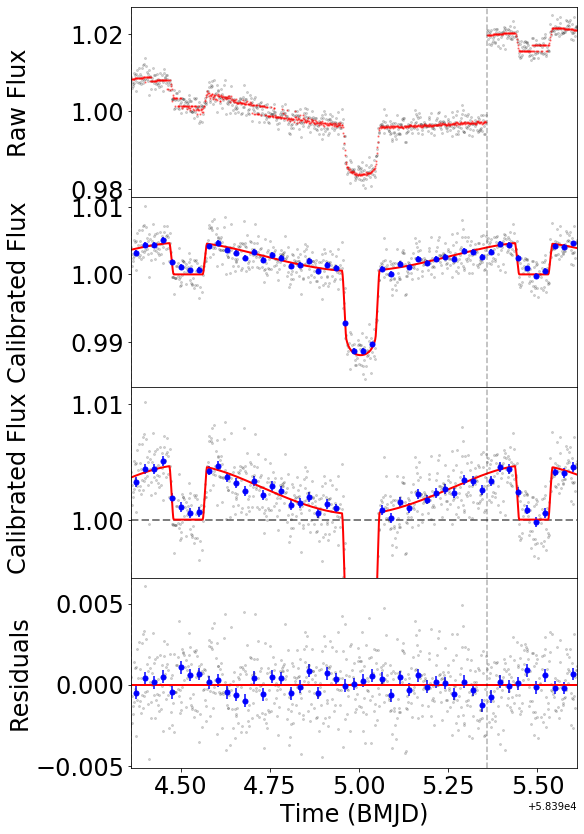

In [46]:
# generate uniformly spaced time array for plot purposes
time2 = np.linspace(np.min(time), np.max(time), 1000)

ind_a = len(p0_astro) # index where the astro params end

# generate the models from best-fit parameters
mcmc_signal = signalfunc(signal_inputs, **dict([[p0_labels[i], p0_mcmc[i]] for i in range(len(p0))]))
mcmc_lightcurve = astrofunc(time, **dict([[p0_astro[i], p0_mcmc[:ind_a][i]] for i in range(len(p0_astro))]))
mcmc_detec = mcmc_signal/mcmc_lightcurve

#for higher-rez red curve
mcmc_lightplot  = astrofunc(time2, **dict([[p0_astro[i], p0_mcmc[:ind_a][i]] for i in range(len(p0_astro))]))


# Differences from eccentricity
# if 'ecosw' in dparams and 'esinw' in dparams:
#     # converting time into orbital phases
#     if 't0' in p0_labels:
#         t0MCMC = p0_mcmc[np.where(p0_labels == 't0')[0][0]]
#     else:
#         t0MCMC = p0_obj['t0']
#     if 'per' in p0_labels:
#         perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
#     else:
#         perMCMC = p0_obj['per']
#     x = (time-t0MCMC)/perMCMC
#     orbNum = int(np.min(x))
#     if np.min(x)>0:
#         orbNum += 1
#     x -= orbNum
# 
#     orb_breaks = np.empty(len(breaks))
#     for j in range(len(breaks)):
#         orb_breaks[j] = ((breaks[j]-t0MCMC)/perMCMC-orbNum)      
# else:
#     x       = time - peritime
#     xbreaks = breaks - peritime

# FIX: peritime isn't defined, so just using time for all plots for now
orb_breaks = breaks
if True:#'ecosw' in dparams and 'esinw' in dparams:
    make_plots.plot_bestfit(time, flux, mcmc_lightcurve, mcmc_detec, mode, orb_breaks, savepath, nbin=bestfitNbin, fontsize=24)
else:
    # FIX: make this default plotting option
    make_plots_custom.plot_bestfit(x, flux, mcmc_lightcurve, mcmc_detec, 
                                   mode, xbreaks, savepath, peritime=0, nbin=bestfitNbin)

In [73]:
make_plots = importlib.reload(make_plots)

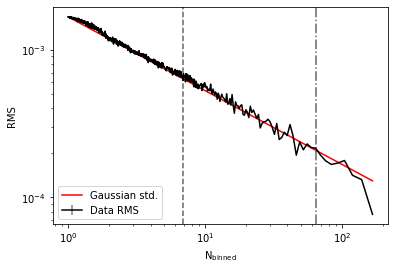

Over Ingress (14.8 min):
Expected Noise (ppm)	Observed Noise (ppm)
639.15665312308	653.9205310420404
Observed/Expected
1.0230989974786624

Over Transit/Eclipse (139.9 min):
Expected Noise (ppm)	Observed Noise (ppm)
208.6407209599807	215.32521542733488
Observed/Expected
1.0320383021904738


In [74]:
#WARNING: these durations assume circular orbits!!!
intTime = (time[1]-time[0])
ingrDuration = helpers.getIngressDuration(p0_mcmc, p0_labels, p0_obj, intTime)
occDuration = helpers.getOccultationDuration(p0_mcmc, p0_labels, p0_obj, intTime)

minBins = 5
residuals = flux/mcmc_detec - mcmc_lightcurve

make_plots.plot_rednoise(residuals, minBins, ingrDuration, occDuration, intTime, mode, savepath, savetxt=True)
plt.close()

In [ ]:
#Binned data
data = flux/mcmc_detec
astro  = mcmc_lightcurve
if 'sigF' in p0_labels:
    sigFMCMC = p0_mcmc[np.where(p0_labels == 'sigF')[0][0]]
else:
    sigFMCMC = p0_obj['sigF']
if 'bliss' in mode.lower():
    nKnotsUsed = len(signal_inputs[-4][signal_inputs[-2]])
    ndim_eff = ndim+nKnotsUsed
else:
    ndim_eff = ndim
chisB = helpers.chi2(data, astro, sigFMCMC)
logLB = helpers.loglikelihood(data, astro, sigFMCMC)
EB = helpers.evidence(logLB, ndim, len(data))
BICB = -2*EB

out = """Binned data:
chi2 = {0}
chi2datum = {1}
Likelihood = {2}
Evidence = {3}
BIC = {4}""".format(chisB, chisB/len(flux), logLB, EB, BICB)

if 'gp' not in mode.lower():
    #Unbinned data
    '''Get model'''
    astro_full   = astrofunc(time_full, **dict([[p0_astro[i], p0_mcmc[:ind_a][i]] for i in range(len(p0_astro))]))
    if 'bliss' in mode.lower():
        signal_inputs_full = bliss.precompute(flux_full, time_full, xdata_full, ydata_full,
                                              psfxw_full, psfyw_full, mode,
                                              astro_full, blissNBin, savepath, False)
    elif 'pld' in mode.lower():
        signal_inputs_full = (flux_full, time_full, Pnorm_full, mode)
        detec_inputs  = (Pnorm, mode)
    elif 'poly' in mode.lower():# and 'psfw' in mode.lower():
        signal_inputs_full = (flux_full, time_full, xdata_full, ydata_full, psfxw_full, psfyw_full, mode)

    signal_full = signalfunc(signal_inputs_full, **dict([[p0_labels[i], p0_mcmc[i]] for i in range(len(p0))]))
    detec_full = signal_full/astro_full
    data_full = flux_full/detec_full

    '''Get Fitted Uncertainty'''
    ferr_full = sigFMCMC*np.sqrt(nFrames)

    N = len(data_full)
    if 'bliss' in mode.lower():
        nKnotsUsed_full = len(signal_inputs_full[-4][signal_inputs_full[-2]])
        ndim_eff_full = ndim+nKnotsUsed_full
    else:
        ndim_eff_full = ndim

    chis = helpers.chi2(data_full, astro_full, ferr_full)
    logL = helpers.loglikelihood(data_full, astro_full, ferr_full)
    E = helpers.evidence(logL, ndim_eff_full, N)
    BIC = -2*E

    out += """

Unbinned data:
chi2 = {0}
chi2datum = {1}
Likelihood = {2}
Evidence = {3}
BIC = {4}""".format(chis, chis/len(flux_full), logL, E, BIC)

with open(savepath+'EVIDENCE_'+mode+'.txt','w') as file:
    file.write(out)
print(out)

In [ ]:
ResultMCMC_Params = Table()

for i in range(len(p0_labels)):
    ResultMCMC_Params[p0_labels[i]] = MCMC_Results[i]

ResultMCMC_Params['offset'] = offset
ResultMCMC_Params['tDay'] = [np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16)]
ResultMCMC_Params['tNight'] = [np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['chi2datum'] = [chisB/len(flux)]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]
ResultMCMC_Params['sigF_photon_ppm'] = [sigF_photon_ppm]

if 'gp' not in mode.lower():
    ResultMCMC_Params['chi2'] = [chis]
    ResultMCMC_Params['logL'] = [logL]
    ResultMCMC_Params['evidence'] = [E]

pathres = savepath + 'ResultMCMC_'+mode+'_Params.npy'
np.save(pathres, ResultMCMC_Params)

In [ ]:
if 'pld' not in mode.lower():
    # determining in-eclipse and in-transit index

    # generating transit model

    if 't0' in p0_labels:
        t0MCMC = p0_mcmc[np.where(p0_labels == 't0')[0][0]]
    else:
        t0MCMC = p0_obj['t0']
    if 'per' in p0_labels:
        perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
    else:
        perMCMC = p0_obj['per']
    if 'rp' in p0_labels:
        rpMCMC = p0_mcmc[np.where(p0_labels == 'rp')[0][0]]
    else:
        rpMCMC = p0_obj['rp']
    if 'a' in p0_labels:
        aMCMC = p0_mcmc[np.where(p0_labels == 'a')[0][0]]
    else:
        aMCMC = p0_obj['a']
    if 'inc' in p0_labels:
        incMCMC = p0_mcmc[np.where(p0_labels == 'inc')[0][0]]
    else:
        incMCMC = p0_obj['inc']
    if 'ecosw' in p0_labels:
        ecoswMCMC = p0_mcmc[np.where(p0_labels == 'ecosw')[0][0]]
    else:
        ecoswMCMC = p0_obj['ecosw']
    if 'esinw' in p0_labels:
        esinwMCMC = p0_mcmc[np.where(p0_labels == 'esinw')[0][0]]
    else:
        esinwMCMC = p0_obj['esinw']
    if 'q1' in p0_labels:
        q1MCMC = p0_mcmc[np.where(p0_labels == 'q1')[0][0]]
    else:
        q1MCMC = p0_obj['q1']
    if 'q2' in p0_labels:
        q2MCMC = p0_mcmc[np.where(p0_labels == 'q2')[0][0]]
    else:
        q2MCMC = p0_obj['q2']
    if 'fp'in p0_labels:
        fpMCMC = p0_mcmc[np.where(p0_labels == 'fp')[0][0]]
    else:
        fpMCMC = p0_obj['fp']

    eccMCMC = np.sqrt(ecoswMCMC**2 + esinwMCMC**2)
    wMCMC   = np.arctan2(esinwMCMC, ecoswMCMC)
    u1MCMC  = 2*np.sqrt(q1MCMC)*q2MCMC
    u2MCMC  = np.sqrt(q1MCMC)*(1-2*q2MCMC)

    trans, t_sec, true_anom = astro_models.transit_model(time, t0MCMC, perMCMC, rpMCMC,
                                                         aMCMC, incMCMC, eccMCMC, wMCMC,
                                                         u1MCMC, u2MCMC)
    # generating secondary eclipses model
    eclip = astro_models.eclipse(time, t0MCMC, perMCMC, rpMCMC, aMCMC, incMCMC, eccMCMC, wMCMC,
                                 fpMCMC, t_sec)

    # get in-transit indices
    ind_trans  = np.where(trans!=1)
    # get in-eclipse indices
    ind_eclip  = np.where((eclip!=(1+fpMCMC)))
    # seperating first and second eclipse
    ind_ecli1 = ind_eclip[0][np.where(ind_eclip[0]<int(len(time)/2))]
    ind_ecli2 = ind_eclip[0][np.where(ind_eclip[0]>int(len(time)/2))]
    
    
    
    residual = flux/mcmc_detec - mcmc_lightcurve

    data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
    data2 = [xdata[ind_ecli1], ydata[ind_ecli1], psfxw[ind_ecli1], psfyw[ind_ecli1], flux[ind_ecli1], residual[ind_ecli1]]
    data3 = [xdata[ind_trans], ydata[ind_trans], psfxw[ind_trans], psfyw[ind_trans], flux[ind_trans], residual[ind_trans]]
    data4 = [xdata[ind_ecli2], ydata[ind_ecli2], psfxw[ind_ecli2], psfyw[ind_ecli2], flux[ind_ecli2], residual[ind_ecli2]]

    plotname = savepath + 'MCMC_'+mode+'_7.pdf'
    make_plots.triangle_colors(data1, data2, data3, data4, plotname)